# Exploratory Data Analysis

Here I explore the dataset in a number of ways, with the goal of understanding it's structure and key characteristics

## Import Packages

In [137]:
# import packages - general
import numpy as np
import pandas as pd

# import packages - geospatial
import xarray as xr

# import packages - plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## User Inputs

Set key values for the script

In [138]:
# set the ice core location (lat,lon)
ice_core_loc = [63.0692, 209]

# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py) (CURRENTLY JUST ONE, BUT CAN ADD MORE)
coords = [[180,240,45,65]]
times = [['1970-01-01','2023-12-31']]  # Ensure the time range is valid

# select which of the list I want to load
coords_num = 0
times_num = 0

## Load data

Note that I set this up to be able to load different datasets as I wish, given my plan to explore multiple different datasets

In [139]:
filename

'era5_subset_180-240_45-65_1970-2023.nc'

In [140]:
# set the path to the data
path_to_ready = '../data/ai_ready/'

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]
filename = f"era5_subset_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}.nc"

# load data
ds = xr.open_dataset(path_to_ready+filename)

In [141]:
# define a list of the variables I'll explore below
vars = ['sst','msl','sp']

## Make Basic Plots of the Data

Just helpful for understanding what we have. 



## First up, I'll plot the average

In theory, this should be zero, thanks to the fact that I've normalized this data to be in anomaly space. However, we do see some slight variability. I think this is probably due to a few things - maybe some rounding error, but mostly the way i remove the seasonal cycle. All in, I think this is close enough to zero that I don't see a problem that needs to be addressed.

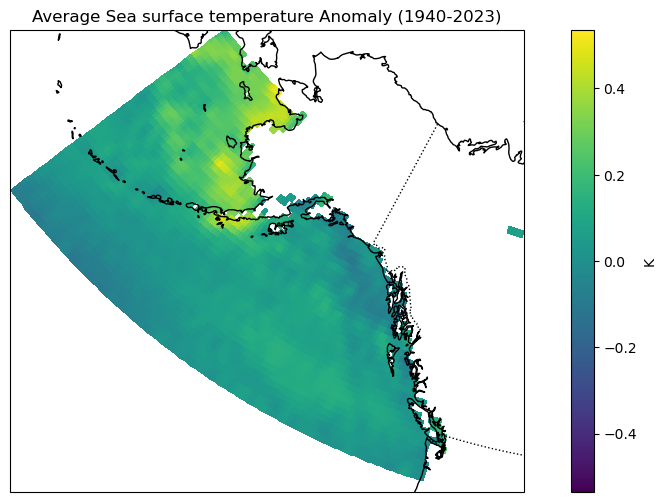

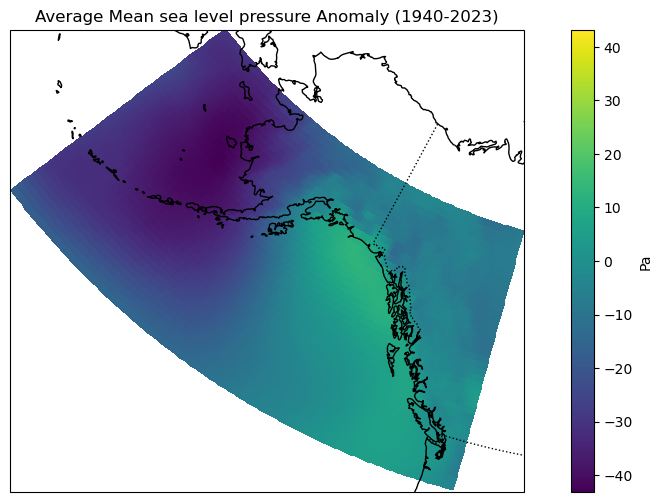

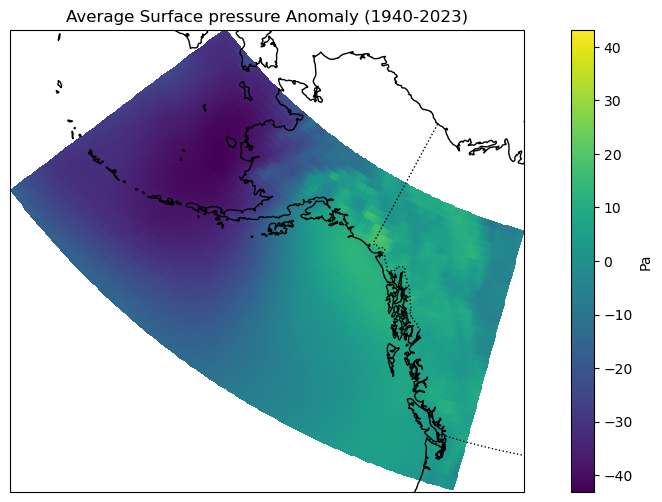

In [142]:
# Loop through
for v in vars:

    # calculate the overall mean
    ave = ds[v].mean(dim='time')


    # Plot the global map of the average 500 hPa geopotential height
    fig,ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.LambertConformal()})
    ax.set_extent([c[0], c[1], c[2], c[3]], crs=ccrs.PlateCarree())
    
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # add coastlines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # plot the data
    ave.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': ds[v].units})

    ax.set_title('Average '+ds[v].long_name+' (1940-2023)')

    plt.show()

### Now plot standard deviation

This gives a sense of where on the map is more and less variable. A couple of things stand out, including
- We see increased variability in SST in the bering sea. I hypothesize that this is driven by SSTs
- Generally, pressure anomalies are greater by the Aleutian Penensula. At first, I though this might be driven by the ocean. But on deeper consideration, I actually think it's driven by the Aleutian low, a powerful semi-permanent low that tends to form in this area. The formation/dissolution of this low would explain the variability observed

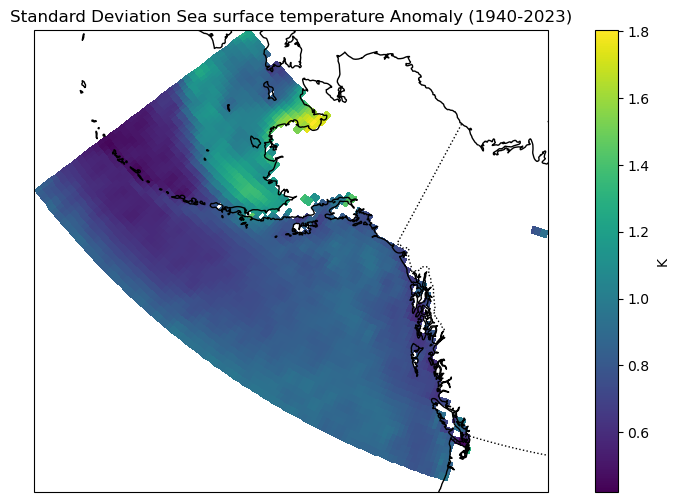

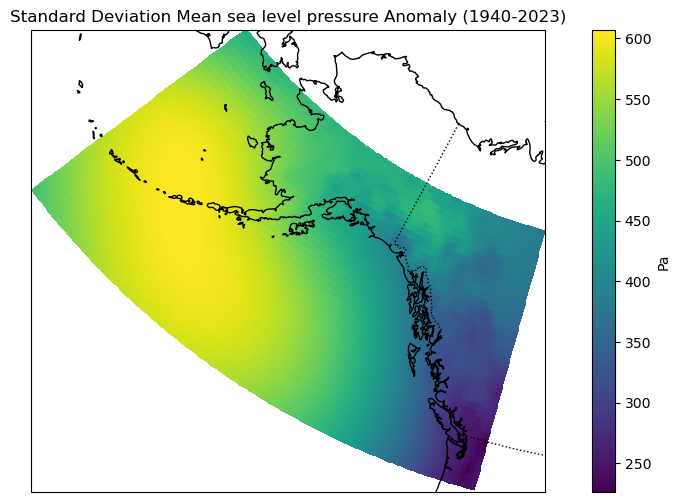

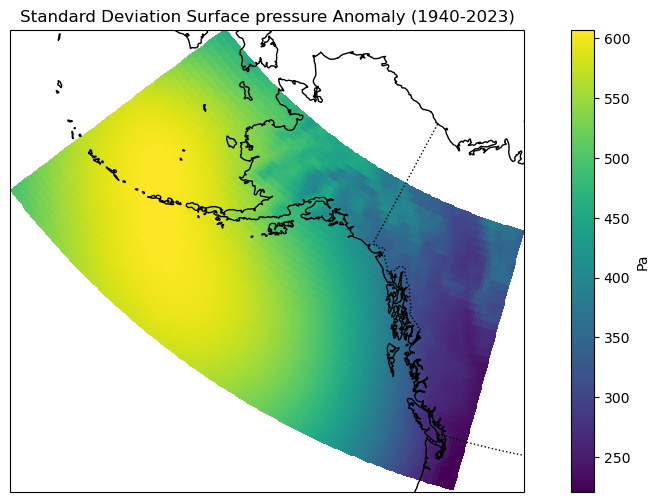

In [143]:
# Now let's plot the standard deviation of the data

# Loop through
for v in vars:

    # calculate the overall standard deviation
    std = ds[v].std(dim='time')

    # Plot the global map of the average 500 hPa geopotential height
    fig,ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.LambertConformal()})
    ax.set_extent([c[0], c[1], c[2], c[3]], crs=ccrs.PlateCarree())
    
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # add coastlines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # plot the data
    std.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': ds[v].units})

    ax.set_title('Standard Deviation '+ds[v].long_name+' (1940-2023)')

    plt.show()

# Now, let's look at the minimum and maximum values for all three variables

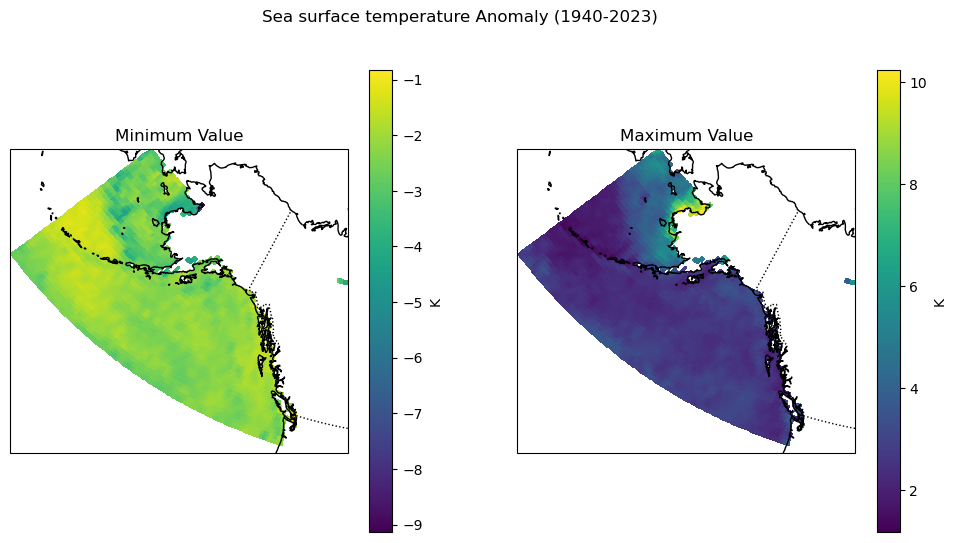

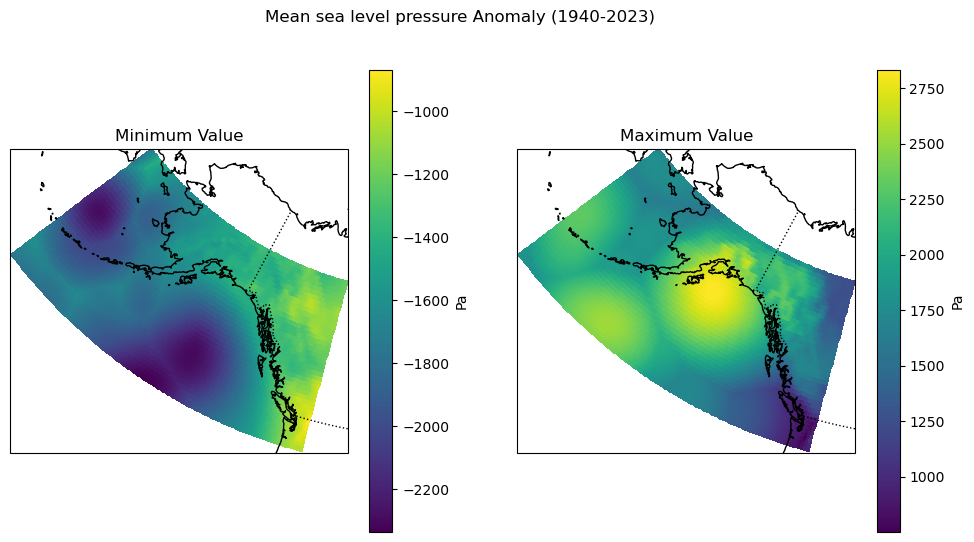

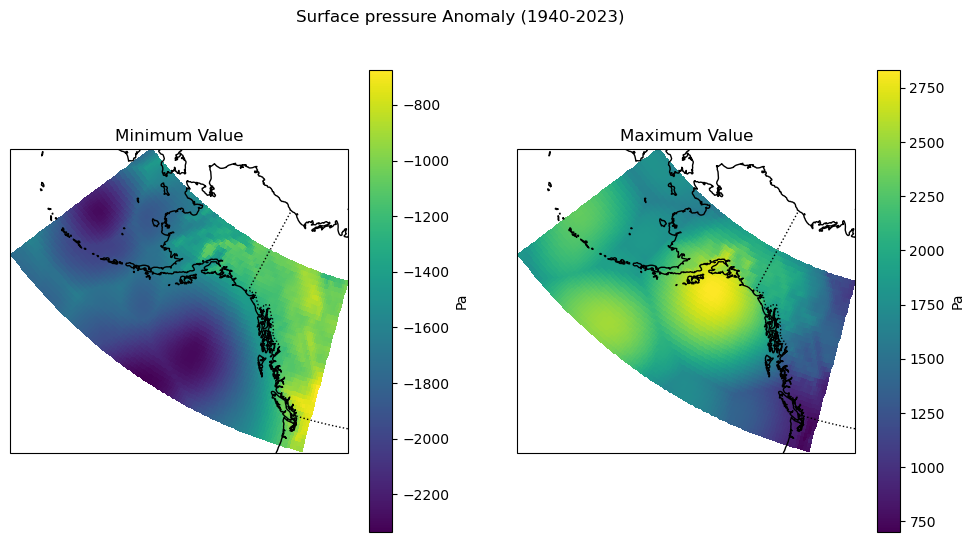

In [144]:
# Loop through
for v in vars:

    # calculate the overall standard deviation
    min_val = ds[v].min(dim='time')
    max_val = ds[v].max(dim='time')

    # Plot the global map of the average 500 hPa geopotential height
    fig,ax = plt.subplots(1,2,figsize=(12, 6),subplot_kw={'projection': ccrs.LambertConformal()})

    for i in range(2):
        ax[i].set_extent([c[0], c[1], c[2], c[3]], crs=ccrs.PlateCarree())
        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        # add coastlines
        ax[i].add_feature(cfeature.COASTLINE)
        ax[i].add_feature(cfeature.BORDERS, linestyle=':')

    # plot the data
    min_val.plot(ax=ax[0], transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': ds[v].units})
    max_val.plot(ax=ax[1], transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': ds[v].units})
    
    fig.suptitle(ds[v].long_name+' (1940-2023)')
    ax[0].set_title('Minimum Value')
    ax[1].set_title('Maximum Value')

    plt.show()

## Examine correlation to data itself at the Ice Core Site

Here I'll look at the Correlation between the data and the datapoint at the ice core site. I skip sst, of course, because we don't have an sst value at the ice core site.

We see that the correlation falls off strongly to near zero even within a couple of hundred miles of the ice core site. This also says something about the autocorrelation of the data - strongly correlated on the mesoscale, but less so on the synoptic scale

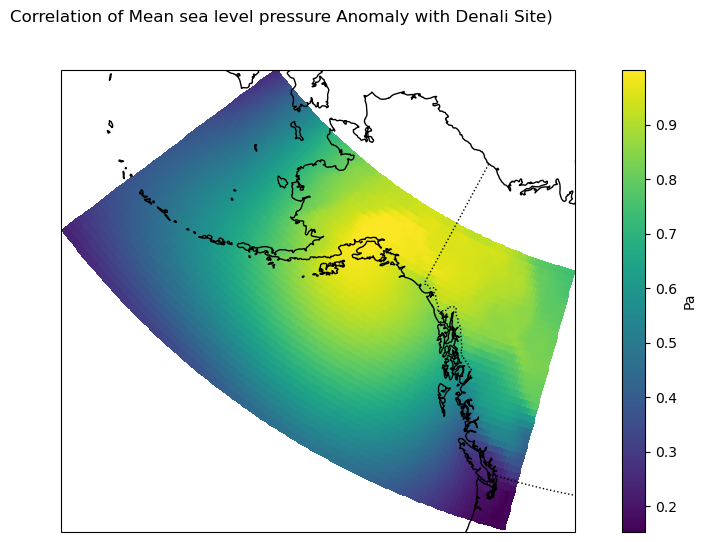

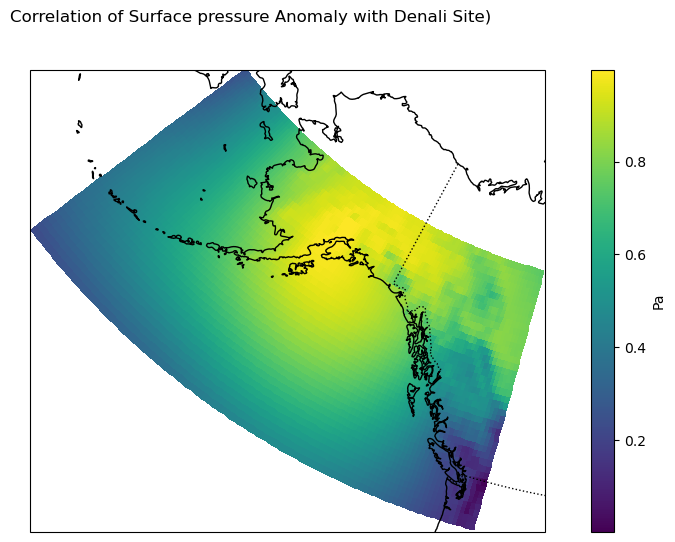

In [153]:
# get ice core location
site_lat = ice_core_loc[0]
site_lon = ice_core_loc[1]

# get the variables I want to correlate
vars_short = ['msl','sp']

# Find the closest grid point in the dataset
ds_site = ds.sel(latitude=site_lat, longitude=site_lon, method="nearest")

for v in vars_short:
    # Extract the SST time series at the closest grid point to the site
    v_site = ds_site[v]

    # Calculate the correlation between this time series and SST at each grid point
    correlation_map = xr.corr(ds[v], msl_site, dim="time")

    # Plot the global map of the average 500 hPa geopotential height
    fig,ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.LambertConformal()})
    ax.set_extent([c[0], c[1], c[2], c[3]], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # add coastlines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    fig.suptitle(f"Correlation of "+ds[v].long_name+" with Denali Site)")
    
    # plot the data
    correlation_map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': ds[v].units})

    plt.show()



# Let's produce some Hisograms of the data

It's too much to produce histograms with ALL of the data on one graph, so I'll limit this to just the ice core site. We can use ds_site as defined above

# Now, let's look at the ice core data itself

In particular, I want to look at correlations between the ice core data (our target data) and these cliamte variables

The ice core data we'll be looking at is d18O and dxs data. d18O is generally seen as a proxy for site temperature, and dxs as a proxy for moisture source temperature. However, the interpretation of both is complicated by topography and seasonal weather patterns at alpine ice core sites, and is not well understood in these reigons. The data includes annual averages from 810-2021.

In [146]:
# Load ice core data (already cleaned from prior work). Includes annual averages of both d18O and dD from 800 A.D. to 2010 A.D.
ice_core = pd.read_csv('../data/cleaned/ice_core.csv')

# find common min and max years between ice core and dataset
min_yr = max([int(t[0][:4]),min(ice_core['Year'])])
max_yr = min([int(t[1][:4]),max(ice_core['Year'])])

# subset the ice core data to the same time range as the dataset
ice_core = ice_core[(ice_core['Year']>=min_yr) & (ice_core['Year']<=max_yr)]

# ensure it is ascending
ice_core.sort_values(by='Year', inplace=True, ascending=True)

# pull out variables
d18O = ice_core['d18O'].to_numpy()
year = ice_core['Year'].to_numpy()
dxs = ice_core['dxs'].to_numpy()

# make xarray dataset with ice core year as dimension and coordinate, and dxs and d18O as variables
ds_ice = xr.Dataset({'d18O': ('time', d18O), 'dxs': ('time', dxs)}, coords={'time': year})


In [147]:
# Now let's sort the xarray object

# subset the ds to the same time range as the ice core
ds_subset = ds.sel(time=slice(str(min_yr),str(max_yr)))
# make annual average from xarray dataset
ds_subset = ds_subset.resample(time='1Y').mean()
# make time units just year instead of datetime64[ns]
ds_subset['time'] = ds_subset['time.year']

/Users/Liam/anaconda3/envs/ess469_final/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


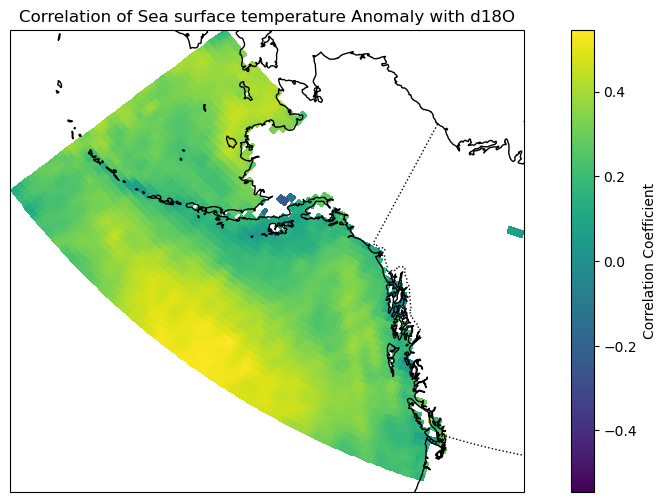

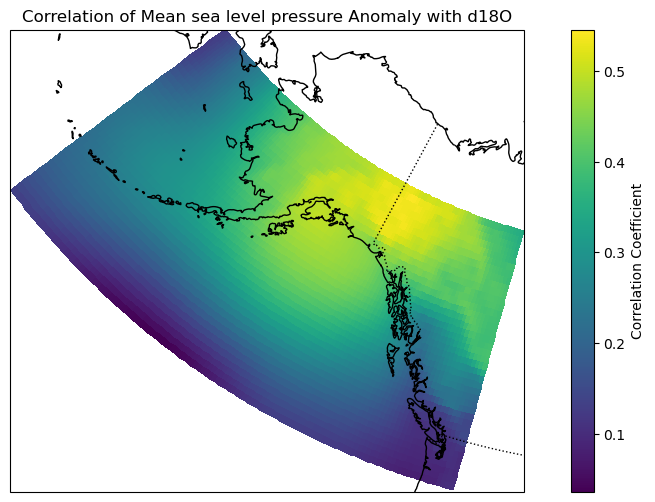

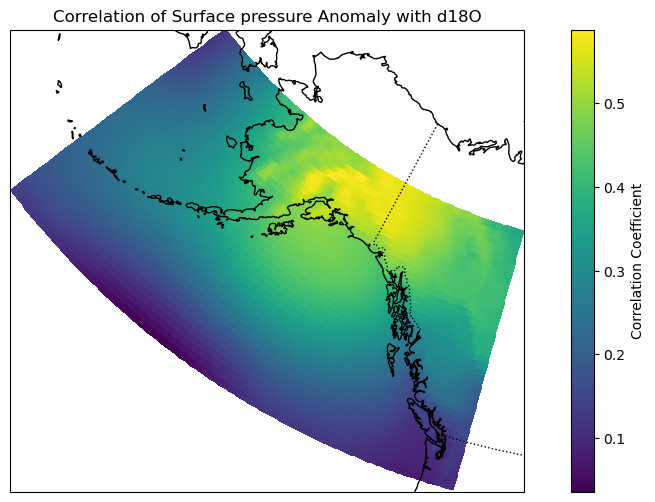

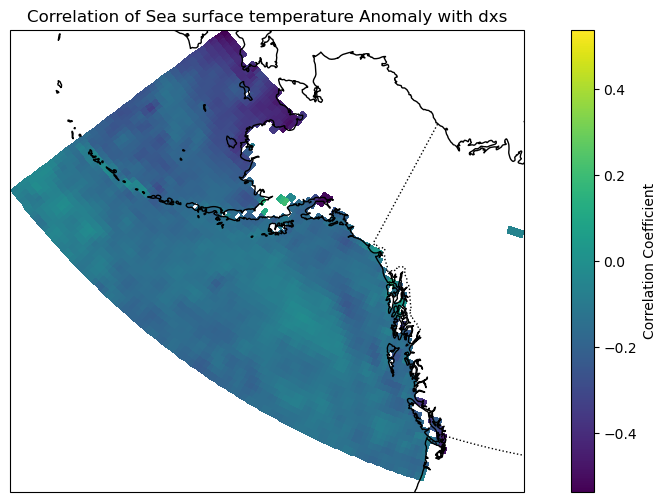

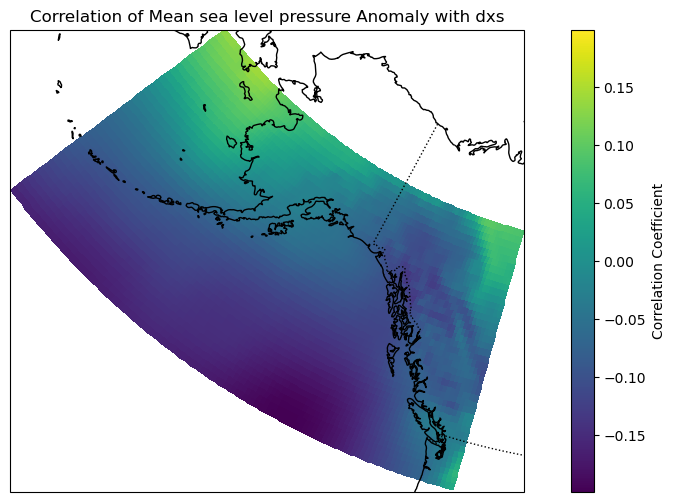

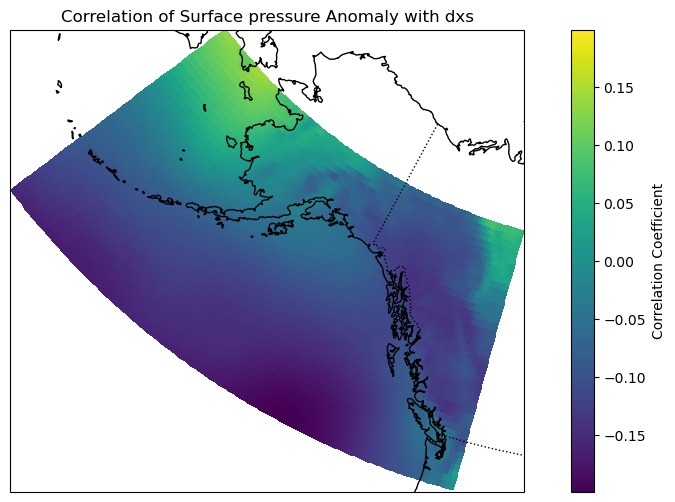

In [148]:
# Now let's correlate the ice core data with the dataset

# loop through proxy
for proxy in ['d18O','dxs']:

    # loop through variables
    for v in vars:

        # calculate the correlation
        correlation = xr.corr(ds_subset[v], ds_ice[proxy], dim="time")

        # Plot the global map of the average 500 hPa geopotential height
        fig,ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.LambertConformal()})
        ax.set_extent([c[0], c[1], c[2], c[3]], crs=ccrs.PlateCarree())
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        # add coastlines
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f"Correlation of "+ds[v].long_name+" with "+name)

        # set the colorbar label
        cbar_label = {'label': "Correlation Coefficient"}
        
        # plot the data
        correlation.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs=cbar_label)

        # set the title
        ax.set_title(f"Correlation of "+ds[v].long_name+" with "+proxy)


        plt.show()
